## Feature Engineering

After cleaning the dataset gene_pam50, we get gene_pam50_redux. A reduction of more than 50% of noisy features has been applied.</br>
Now, for further feature engineering and optimizing the predictive power of features, the following techniques are being executed:

In [600]:
#Importing libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [601]:
print(os.getcwd())

c:\Users\ntama\Documentos\Data Science\My Projects\breast-cancer-gene-test\notebooks


In [602]:
#Importing the reduced dataset
gene_pam50_redux = pd.read_csv('../processed/gene_pam50_redux.csv', index_col=0)
gene_pam50_redux.head()

,SampleID,5S_rRNA,A1BG,A2M,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pam50 subtype
0,F1,4.911099,0.598115,6.172477,2.338407,3.494541,3.316944,2.615362,3.295121,1.801903,...,2.918632,1.108204,3.044573,2.425306,3.244432,1.468899,6.281767,1.774107,2.437227,Basal
1,F2,-3.321928,2.363673,7.113514,2.806512,4.128479,3.704010,2.411364,3.967500,2.155626,...,2.551831,1.678388,2.743902,1.861781,2.727427,1.924761,7.169613,1.764214,2.876100,LumA
2,F3,-3.321928,2.647738,5.641996,2.046831,3.906716,3.948050,2.354602,4.036218,2.610794,...,3.319094,2.443392,4.719843,1.365396,3.122333,1.619277,6.683400,2.039246,2.929346,LumB
3,F4,3.656393,1.378576,7.236769,3.740478,4.124308,4.064205,2.296178,4.422369,2.324835,...,2.588427,2.441704,4.157466,2.038984,3.182823,1.969433,6.666306,2.771650,2.777674,LumA
4,F5,4.190104,2.759643,7.508171,3.309973,3.719936,3.625562,2.876102,4.065878,2.373666,...,2.243450,1.749230,1.024820,2.032704,3.588842,2.998474,6.479006,2.696269,3.957146,Normal


#### Defining train, validation and test datasets

In [603]:
X = gene_pam50_redux.drop('pam50 subtype', axis=1).copy()
y = gene_pam50_redux[['pam50 subtype']].copy()
#to ensure keeping class proportions in the split, we use stratify=y parameter
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"X sets - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"y sets - Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

X sets - Train: (2386, 13622), Val: (511, 13622), Test: (512, 13622)
y sets - Train: (2386, 1), Val: (511, 1), Test: (512, 1)


In [604]:
#Separating X_train numeric features from 'SampleID' (object) for scaling
X_train_num = X_train.select_dtypes(include=['number'])
X_val_num = X_val.select_dtypes(include=['number'])
X_test_num = X_test.select_dtypes(include=['number'])

In [605]:
print(f"Train: {X_train_num.shape}, Val: {X_val_num.shape}, Test: {X_test_num.shape}")

Train: (2386, 13621), Val: (511, 13621), Test: (512, 13621)


#### Scaling X

In [606]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_val_scaled = scaler.transform(X_val_num)
X_test_scaled = scaler.transform(X_test_num)

#converting again into pd.DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index)

### Principal Component Analysis (PCA)

First object to inspect number of PC's

In [607]:
#Defining a first PCA object for inspection.
pca = PCA()
pca.fit(X_train_scaled_df)

PCA()

How many principal axes do we need?

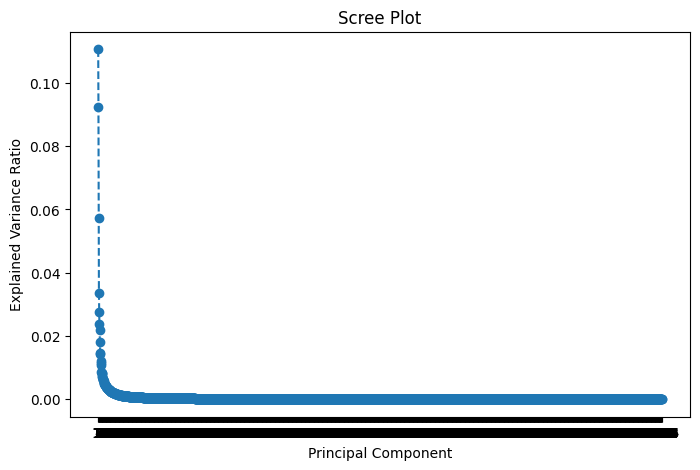

In [608]:
# Explained variance
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1),
         explained_variance,
         marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

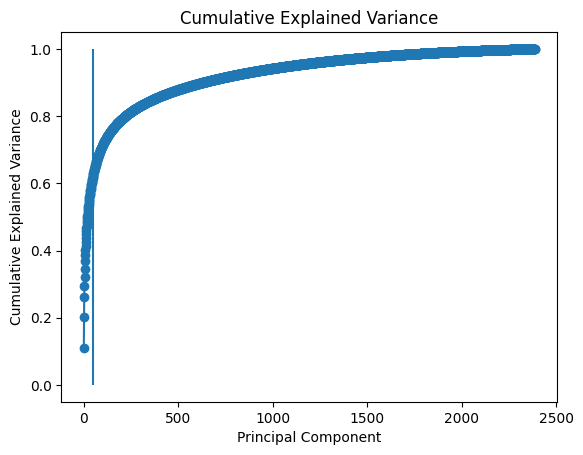

In [609]:
plt.plot(range(1, len(explained_variance) + 1),
         explained_variance.cumsum(),
         marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.vlines(x=50, ymin=0, ymax=1)
plt.show()

`With 50 PC's there is around 60% of the variance explained`

Defining a second object with 50 principal components

In [610]:
pca_2 = PCA(n_components=50)
X_train_pca = pca_2.fit_transform(X_train_scaled_df)

In [611]:
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(50)], index=X_train.index)

Visualizing PC1 vs. PC2 and PC2 vs. PC3

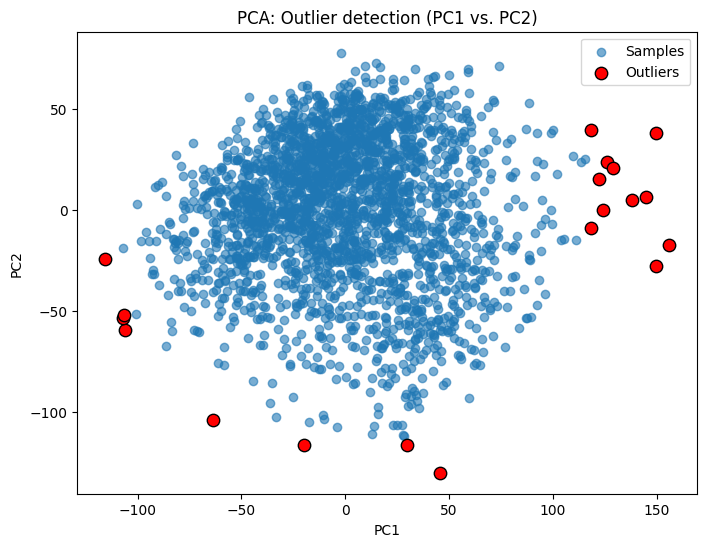

In [612]:

coords = X_train_pca_df[["PC1", "PC2"]].values
center = coords.mean(axis=0)
distances = np.linalg.norm(coords - center, axis=1)
threshold = distances.mean() + 3 * distances.std()
outliers = distances > threshold

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca_df["PC1"], X_train_pca_df["PC2"], alpha=0.6, label="Samples")
plt.scatter(X_train_pca_df.loc[outliers, "PC1"], 
            X_train_pca_df.loc[outliers, "PC2"], 
            color="red", edgecolor="black", s=80, label="Outliers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: Outlier detection (PC1 vs. PC2)")
plt.legend()
plt.show()

Which samples are these outliers?</br>

In [613]:
outlier_ids = (X_train_pca_df.index[outliers]) 
outlier_ids = list(outlier_ids)
print("These are indices from X_train_pca_df")
print(outlier_ids)

These are indices from X_train_pca_df
[1652, 1325, 597, 3350, 2179, 1299, 805, 1298, 3012, 1967, 3029, 2005, 630, 815, 424, 3084, 3006, 3404, 1062]


In [614]:
display(X_train_pca_df.iloc[[outlier_ids[0]]])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
752,-0.113581,27.073105,7.718064,-14.448093,7.775521,-17.584122,-0.417039,9.468557,4.865056,4.999064,...,-2.251298,-2.016004,1.112588,-6.462145,0.821231,-0.168075,3.953256,0.279816,0.193177,2.831938


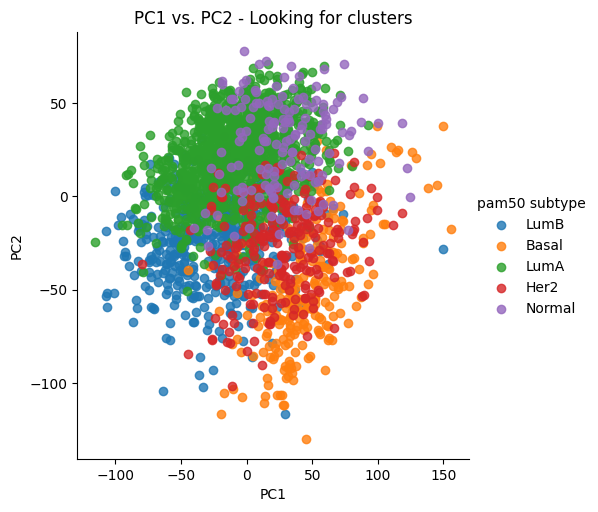

In [615]:
import seaborn as sns
pca_df = pd.concat([X_train_pca_df, y_train], axis=1)
sns.lmplot(x='PC1', y='PC2', data=pca_df, hue='pam50 subtype', fit_reg=False)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs. PC2 - Looking for clusters")
plt.show()

In [616]:
print(X_train_pca_df.shape)
print(y_train.shape)

(2386, 50)
(2386, 1)


In [617]:
pca_df.shape

(2386, 51)

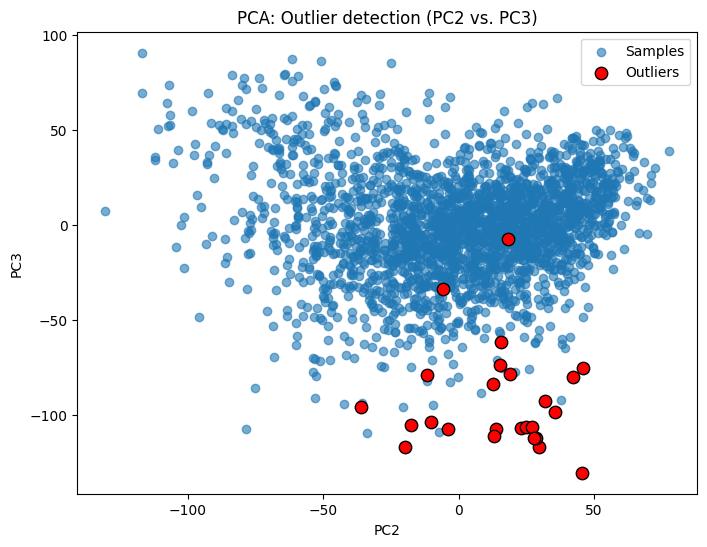

In [618]:

coords2 = X_train_pca_df[["PC2", "PC3"]].values
center2 = coords2.mean(axis=0)
distances2 = np.linalg.norm(coords2 - center2, axis=1)
threshold2= distances2.mean() + 3 * distances2.std()
outliers2 = distances2 > threshold2

plt.figure(figsize=(8,6))
plt.scatter(X_train_pca_df["PC2"], X_train_pca_df["PC3"], alpha=0.6, label="Samples")
plt.scatter(X_train_pca_df.loc[outliers2, "PC1"], 
            X_train_pca_df.loc[outliers2, "PC2"], 
            color="red", edgecolor="black", s=80, label="Outliers")
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PCA: Outlier detection (PC2 vs. PC3)")
plt.legend()
plt.show()

Getting outliers that aren't in the previous list

In [619]:
outlier2_ids_all = (X_train_pca_df.index[outliers2]) #row index +1 to make it match with FXXX

for idx in outlier2_ids_all:
    outlier2_ids = []
    if idx not in outlier_ids:
        outlier2_ids.append(idx)

print(outlier2_ids)

[3310]


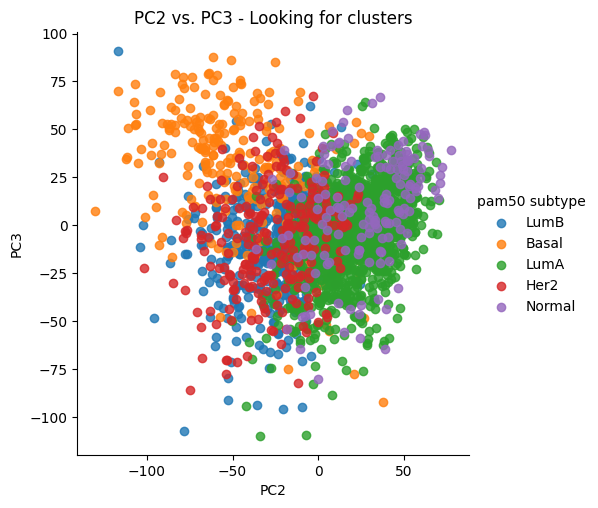

In [620]:
sns.lmplot(x='PC2', y='PC3', data=pca_df, hue='pam50 subtype', fit_reg=False)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PC2 vs. PC3 - Looking for clusters")
plt.show()

`Observation`: There are five clusters observed when plotting the scatter plots PC1-PC2 or PC2-PC3

Getting X_pca for validation and test sets

In [621]:
X_val_pca = pca_2.transform(X_val_scaled)
X_test_pca = pca_2.transform(X_test_scaled)

#Also naming columns with Principal Components
X_val_pca_df = pd.DataFrame(X_val_pca, columns=[f"PC{i+1}" for i in range(50)], index=X_val.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(50)], index=X_test.index)

#### Are these outliers technical (sequencing quality, rare batch) or biological (tumor subtypes, rare mutations)?

Checking these patients in 'clinic_data.csv' (clinic metadata)

In [622]:
#importing clinic_data.csv
clinic_data = pd.read_csv('../processed/clinic_data.csv', index_col=0)
clinic_data.head()

,scan-b external id,instrument model,age at diagnosis,tumor size,lymph node group,lymph node status,er status,pgr status,her2 status,ki67 status,...,nhg prediction mgc,er prediction sgc,pgr prediction sgc,her2 prediction sgc,ki67 prediction sgc,pam50 subtype,overall survival days,overall survival event,endocrine treated,chemo treated
SampleID,,,,,,,,,,,,,,,,,,,,,
F1,Q008818.C008840.S000215.l.r.m2.c.lib.g.k.a.t,HiSeq 2000,43,9.0,NodeNegative,NodeNegative,NaN,NaN,0.0,NaN,...,G3,0,0,0,1,Basal,2367,0,0.0,1.0
F2,Q008769.C008792.S000250.l.r.m.c.lib.g.k.a.t,HiSeq 2000,48,14.0,1to3,NodePositive,1.0,1.0,0.0,NaN,...,G2,1,1,0,0,LumA,2367,0,1.0,1.0
F3,Q008568.C008577.S000424.l.r.m3.c.lib.g.k.a.t,HiSeq 2000,69,27.0,4toX,NodePositive,1.0,1.0,0.0,NaN,...,G3,1,1,0,1,LumB,2168,1,1.0,1.0
F4,Q008909.C009000.S000084.l.r.m.c.lib.g.k.a.t,HiSeq 2000,39,51.0,1to3,NodePositive,1.0,NaN,1.0,NaN,...,G3,1,1,1,1,LumA,2416,0,1.0,1.0
F5,Q008781.C008782.S000260.l.r.m.c.lib.g.k.a.t,HiSeq 2000,73,60.0,4toX,NodePositive,1.0,NaN,0.0,NaN,...,G2,1,1,0,0,Normal,2389,0,1.0,0.0


In [623]:
print(clinic_data.columns)

Index(['scan-b external id', 'instrument model', 'age at diagnosis',
       'tumor size', 'lymph node group', 'lymph node status', 'er status',
       'pgr status', 'her2 status', 'ki67 status', 'nhg', 'er prediction mgc',
       'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc',
       'nhg prediction mgc', 'er prediction sgc', 'pgr prediction sgc',
       'her2 prediction sgc', 'ki67 prediction sgc', 'pam50 subtype',
       'overall survival days', 'overall survival event', 'endocrine treated',
       'chemo treated'],
      dtype='object')


Filtering only patients detected as outliers (indexes)

In [624]:
outlier_ids.append(outlier2_ids[0])
print(outlier_ids)

[1652, 1325, 597, 3350, 2179, 1299, 805, 1298, 3012, 1967, 3029, 2005, 630, 815, 424, 3084, 3006, 3404, 1062, 3310]


Getting the number of sample (patient) for these indexes

In [625]:
idxs = []
for idx in outlier_ids:
    idxs.append(X_train['SampleID'].loc[idx])

print(idxs)

['F1653', 'F1326', 'F598', 'F1748repl', 'F2180', 'F1300', 'F806', 'F1299', 'F3013', 'F1968', 'F3030', 'F2006', 'F631', 'F816', 'F425', 'F3085', 'F3007', 'F3085repl', 'F1063', 'F785repl']


In [626]:

outliers_df = clinic_data.loc[idxs]

display(outliers_df)

,scan-b external id,instrument model,age at diagnosis,tumor size,lymph node group,lymph node status,er status,pgr status,her2 status,ki67 status,...,nhg prediction mgc,er prediction sgc,pgr prediction sgc,her2 prediction sgc,ki67 prediction sgc,pam50 subtype,overall survival days,overall survival event,endocrine treated,chemo treated
SampleID,,,,,,,,,,,,,,,,,,,,,
F1653,Q006473.C006495.S002607.l.r.m.c.lib.g.k.a.t,HiSeq 2000,63,23.0,1to3,NodePositive,0.0,0.0,0.0,NaN,...,G3,0,0,0,1,Basal,1713,0,0.0,1.0
F1326,Q004943.C004993.S004163.l.r.m2.c.lib.g.k.a.t,HiSeq 2000,43,11.0,1to3,NodePositive,1.0,1.0,0.0,0.0,...,G2,0,0,0,0,Basal,1363,0,1.0,1.0
F598,Q008671.C008669.S000346.l.r.m2.c.lib.g.k.a.t,NextSeq 500,72,12.0,NodeNegative,NodeNegative,0.0,0.0,1.0,NaN,...,G3,0,0,1,0,Her2,2306,0,0.0,0.0
F1748repl,Q005593.C005651.S003500.l.r.m2.c.lib.g.k.a.t,HiSeq 2000,62,23.0,NodeNegative,NodeNegative,1.0,1.0,0.0,1.0,...,G2,1,1,0,1,LumB,1523,0,1.0,1.0
F2180,Q005485.C005538.S003623.l.r.m.c.lib.g.k.a.t,HiSeq 2000,82,40.0,NodeNegative,NodeNegative,1.0,1.0,0.0,1.0,...,G3,1,0,0,1,LumB,1530,0,1.0,0.0
F1300,Q005812.C005867.S003266.l.r.m.c.lib.g.k.a.t,HiSeq 2000,70,NaN,NodeNegative,NodeNegative,0.0,0.0,0.0,1.0,...,G2,0,0,0,0,Basal,1543,0,0.0,1.0
F806,Q006696.C006744.S002357.l.r.m.c.lib.g.k.a.t,HiSeq 2000,27,40.0,1to3,NodePositive,0.0,0.0,0.0,NaN,...,G3,1,0,0,1,Basal,1795,0,0.0,1.0
F1299,Q006017.C006076.S003045.l.r.m.c.lib.g.k.a.t,HiSeq 2000,79,16.0,NodeNegative,NodeNegative,1.0,1.0,0.0,0.0,...,G3,0,0,0,1,LumB,1579,0,0.0,0.0
F3013,Q005944.C005971.S003137.l.r.m.c.lib.g.k.a.t,HiSeq 2000,60,1.0,NodeNegative,NodeNegative,1.0,1.0,1.0,0.0,...,G2,1,0,0,0,Normal,1583,0,0.0,0.0


At first, seems complicated to distinguish patterns in the outliers dataset, therefore, defining a nature for outliers isn't possible unless there's a cross-check

#### Getting boxplots and histplots for these samples

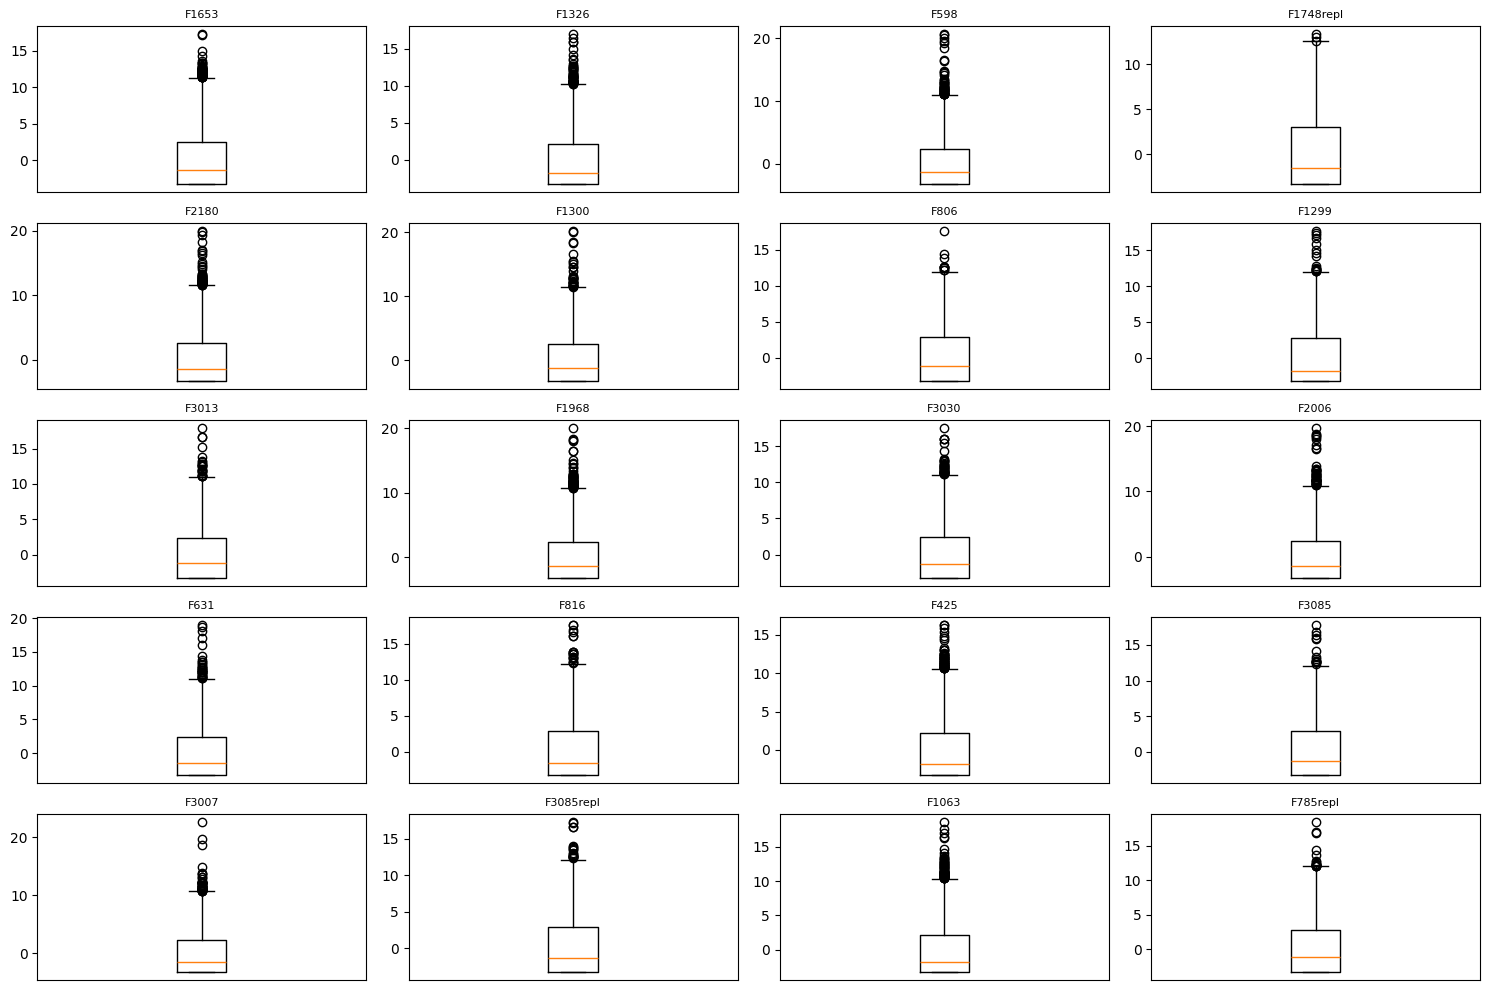

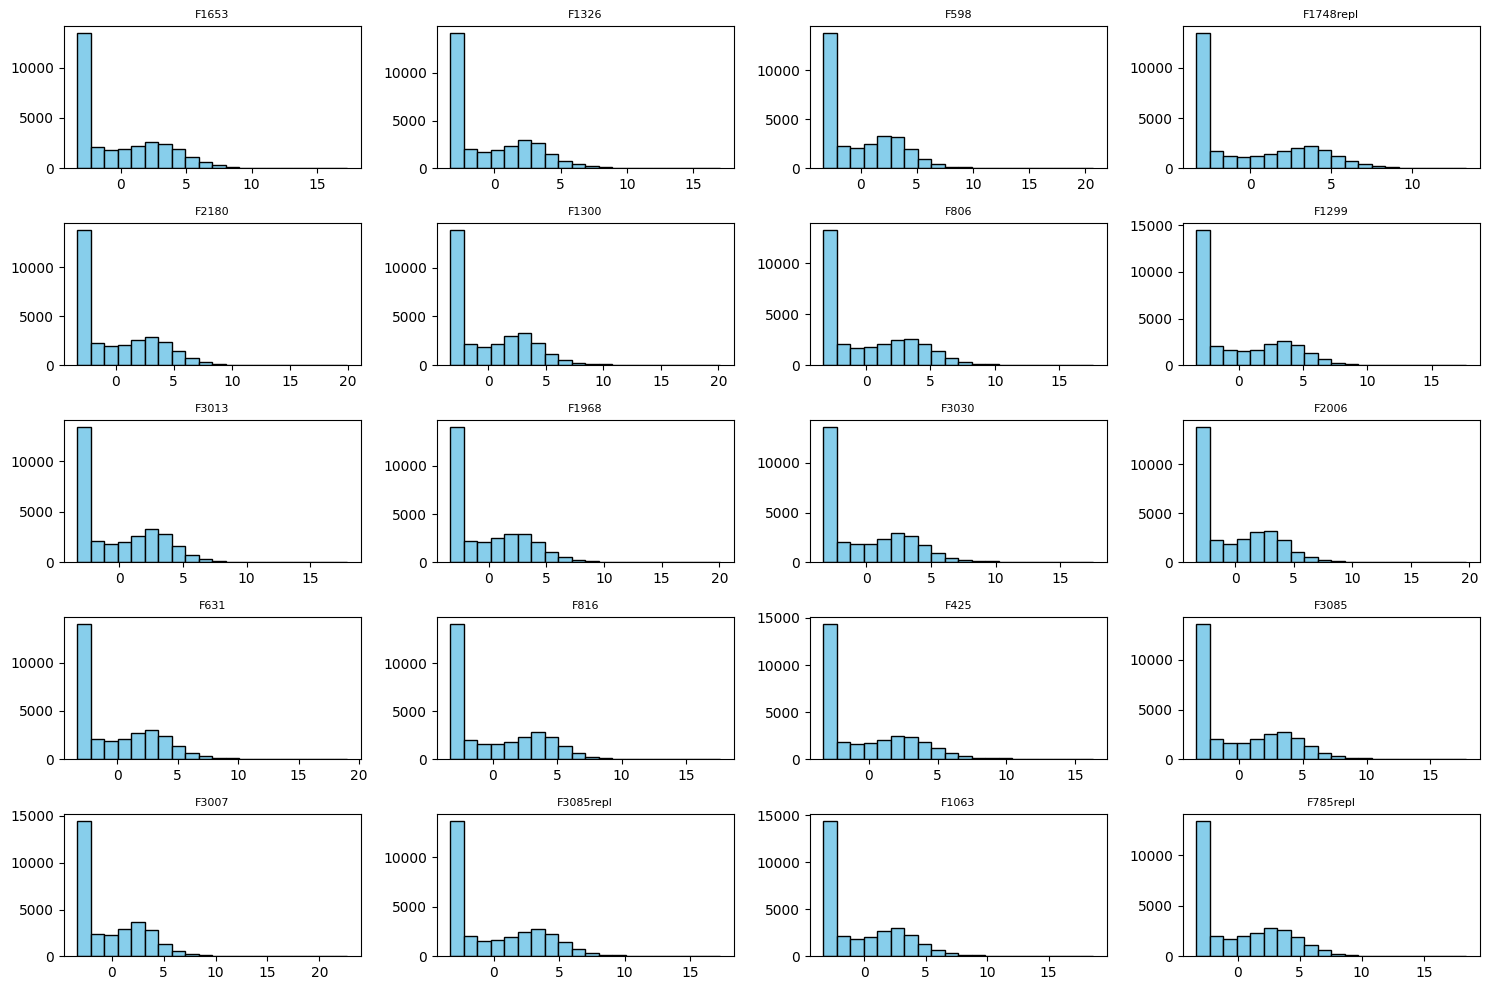

In [627]:
import sys
sys.path.append("..")
from src.plots import *

#importing the original dataset 
gene_pam50 = pd.read_csv("../processed/gene_pam50.csv", index_col='SampleID')

#getting the series with outliers for plotting
outlier_samples_series = []
for i in idxs:
    outlier_sample = gene_pam50.loc[i]
    outlier_samples_series.append(outlier_sample)

plotter1 = Plotter1(df=outlier_samples_series)
plotter1.boxplotter()

plotter2 = Plotter2(df=outlier_samples_series)
plotter2.histplotter()

After plotting outliers and visualizing their clinical data, there isn't a particular sample that shows a specific sign of technical or biological flaw. `For now, outliers are preserved and possibly after assessing metrics a new version excluding outliers could be considered`

### Performing a cross-check with UMAP

In [628]:
import umap.umap_ as umap

umap_model = umap.UMAP(
    n_neighbors=2000, #size of the local neighborhood
    min_dist=0.001, #minimum distance apart that points are allowed to be in the low dimensional representation
    n_components=2,
    metric='cosine',
    random_state=42
)

In [629]:
X_train_umap = umap_model.fit_transform(X_train_pca_df) #this is the embedding
X_train_umap.shape

C:\Users\ntama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(2386, 2)

Visualization of UMAP projection

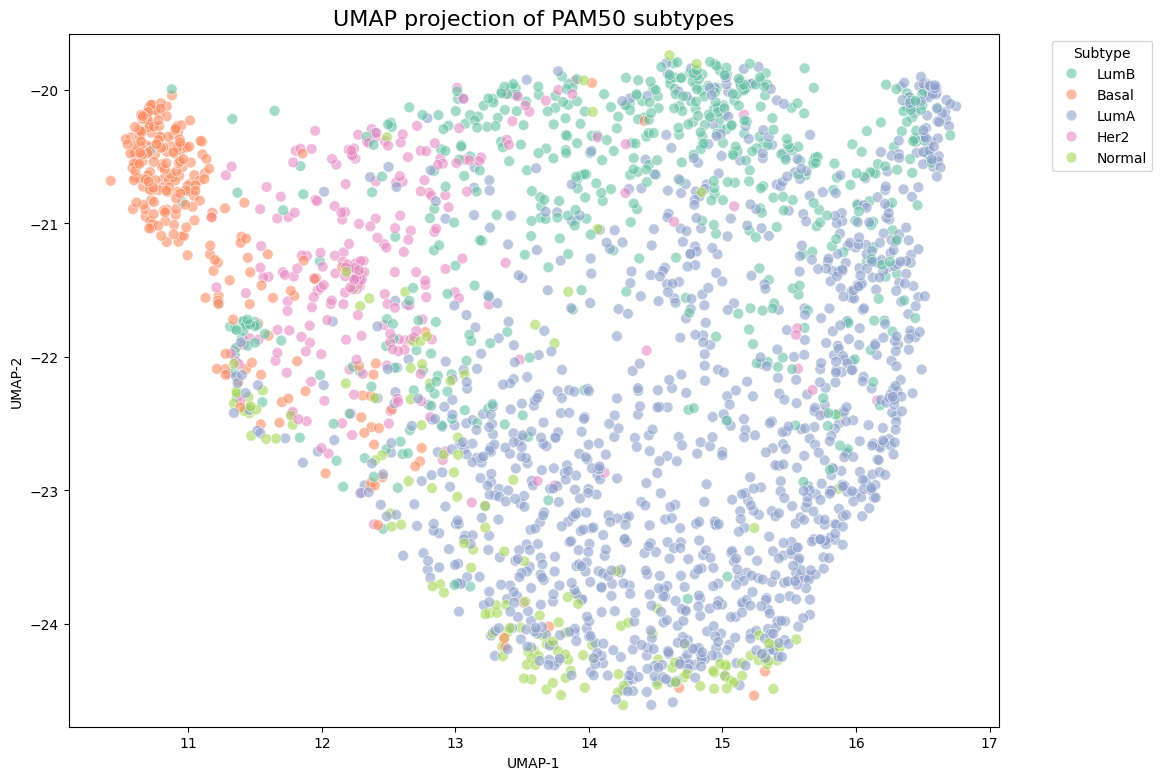

In [630]:
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x=X_train_umap[:, 0],
    y=X_train_umap[:, 1],
    hue=pca_df['pam50 subtype'],
    palette="Set2",   # paleta clara y diferenciada
    alpha=0.6,        # transparencia para ver densidad
    s=60              # tamaño de puntos
)

plt.gca().set_aspect('equal', 'datalim')
plt.title("UMAP projection of PAM50 subtypes", fontsize=16)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Subtype", bbox_to_anchor=(1.05, 1), loc='upper left')  # leyenda fuera
plt.show()

#### Interpretation:

##### Separability and overlapping
- `Basal:` Clearly isolated at top left part of the plot, suggesting expression profiles differentiated from the rest.
- `LumA and LumB`: Good separability, but observing clear overlapped similarities bilogically. Classification is not entirely dychotomic.
- `Her2`: Located between Basal, LumA and LumB, showing that some of these cases can have mixed or intermediate genetic profiles.
- `Normal`: Low participation, showing that it can also share some similarities or profiles with LumA

#### Heterogenicity among subtypes
- `LumA`: Large region -> high heterogenicity among this group.

#### Gradients
- The distribution is not completely discrete, there are some clusters connected by a continuous gradient, which can indicate biological transitions or tumors with intermediate profiles.

### Exporting datasets for supervised learning model training

In [631]:
X_train_pca_df.to_csv("../processed/X_train_pc.csv")
X_val_pca_df.to_csv("../processed/X_val_pc.csv")
X_test_pca_df.to_csv("../processed/X_test_pc.csv")

In [632]:
y_train.to_csv("../processed/y_train.csv")
y_val.to_csv("../processed/y_val.csv")
y_test.to_csv("../processed/y_test.csv")